<a href="https://colab.research.google.com/github/khoji-code/Data-Analysis/blob/main/Credit_Card_Default_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credit Card Default Prediction

***

### **Project Overview**

* **Goal:** To build a machine learning model that accurately predicts the probability of a credit card client defaulting on their next payment.
* **Dataset:** Utilizes the "Default of Credit Card Clients" dataset from the UCI Machine Learning Repository, which contains demographic information, credit history, and payment status for 30,000 clients.
* **Methodology:** The project involves exploratory data analysis (EDA) to understand the relationships between different client attributes and the likelihood of default. A LightGBM classification model is trained, with a strong focus on handling the class imbalance between defaulters and non-defaulters using `scale_pos_weight`. The model's performance is evaluated using ROC AUC and Precision-Recall curves.
* **Key Insights:** The analysis reveals that past payment history is a highly significant predictor of future default. The model achieves a ROC AUC score of **0.7736**, demonstrating its effectiveness in identifying clients at risk of default.

***

### **Purpose**

* **Risk Assessment:** To develop a reliable model that can help financial institutions assess the credit risk of their clients and make more informed lending decisions.
* **Early Intervention:** To identify clients who are at a high risk of defaulting, allowing for proactive intervention and the implementation of strategies to prevent default, such as offering financial counseling or restructuring payment plans.
* **Improve Financial Stability:** To enhance the overall financial stability of lending institutions by reducing the rate of default and minimizing financial losses.

### Dataset:
https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients

## IMPORT LIBRARIES

In [1]:
# Installing Libs
!pip install -q openpyxl lightgbm xlrd

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc
import lightgbm as lgb
import warnings

# Explain: Ignore warnings for a cleaner output.
warnings.filterwarnings('ignore')
print("Libraries imported successfully.")

Libraries imported successfully.


## LOAD AND PREPARE DATA

In [4]:
try:
    # FIX: Using pd.read_excel to correctly handle the .xls file format.
    df = pd.read_excel('/content/drive/MyDrive/credit card/default of credit card clients.xls', header=1)
    print("Dataset loaded successfully. Shape:", df.shape)
except FileNotFoundError:
    print("Error: 'default of credit card clients.xls' not found. Please upload the file.")
    exit()
except Exception as e:
    print(f"An error occurred while reading the Excel file: {e}")
    exit()

Dataset loaded successfully. Shape: (30000, 25)


### Data Cleaning and Renaming

In [5]:
# drop the 'ID' column - not a predictive feature
df.drop(columns=['ID'], inplace=True)
df.rename(columns={
    'default payment next month': 'default',
    'PAY_0': 'pay_1', 'PAY_2': 'pay_2', 'PAY_3': 'pay_3',
    'PAY_4': 'pay_4', 'PAY_5': 'pay_5', 'PAY_6': 'pay_6'
}, inplace=True)
df.columns = [x.lower() for x in df.columns]

In [6]:
# Correcting Categorical Data
# EDUCATION and MARRIAGE - This prevents the model from misinterpreting these values
df['education'] = df['education'].replace([0, 5, 6], 4) # Group 0, 5, 6 into 'Other' (4)
df['marriage'] = df['marriage'].replace(0, 3) # Group 0 into 'Other' (3)

# PAY_X columns have values -2 and -1 which, along with 0 - group them into a single '0' category
for col in ['pay_1', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']:
    df[col] = df[col].replace([-2, -1], 0)

print("\nData cleaned and prepared.")
print("\nEducation categories:", sorted(df['education'].unique()))
print("Marriage categories:", sorted(df['marriage'].unique()))
print("Payment status categories:", sorted(df['pay_1'].unique()))


Data cleaned and prepared.

Education categories: [np.int64(1), np.int64(2), np.int64(3), np.int64(4)]
Marriage categories: [np.int64(1), np.int64(2), np.int64(3)]
Payment status categories: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8)]


## EXPLORATORY DATA ANALYSIS (EDA)

### Payment History Correlation Heatmap

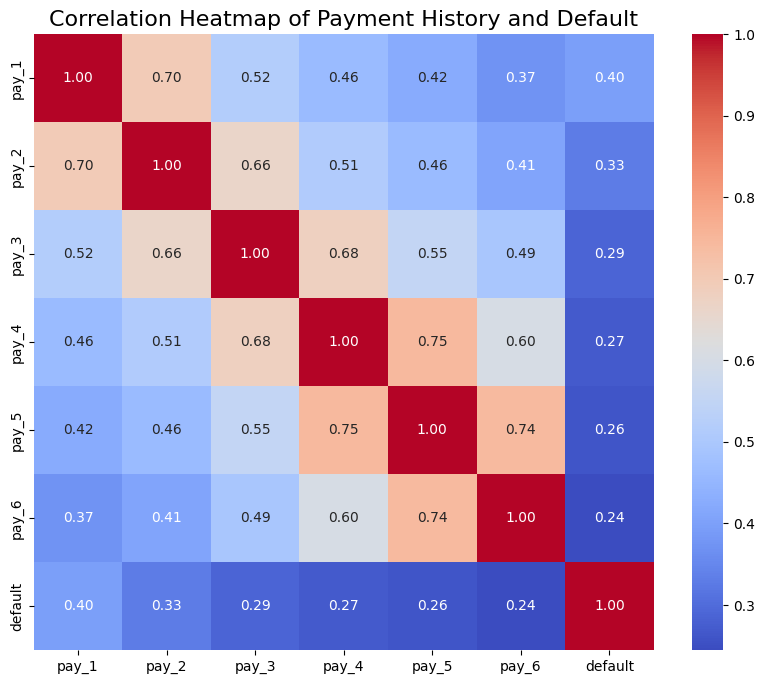

In [7]:
pay_cols = ['pay_1', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'default']
plt.figure(figsize=(10, 8))
sns.heatmap(df[pay_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Payment History and Default', fontsize=16)
plt.show()

### Multi-dimensional Violin Plots

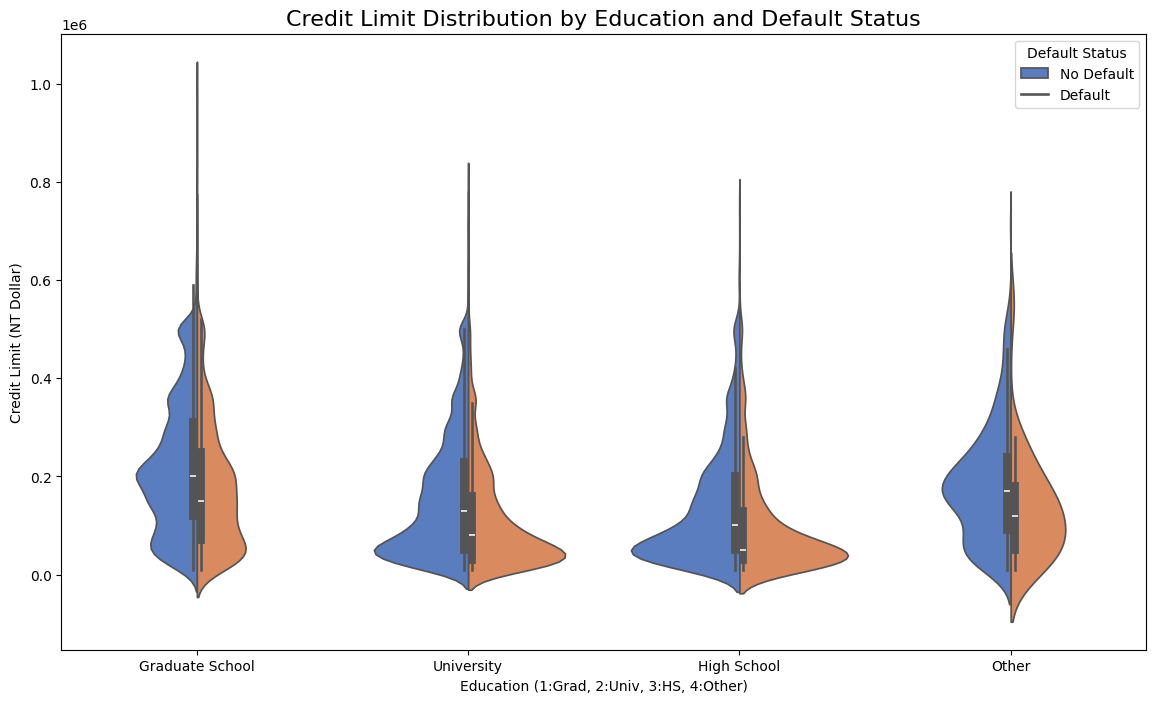

In [8]:
plt.figure(figsize=(14, 8))
sns.violinplot(x='education', y='limit_bal', hue='default', data=df, split=True, palette='muted')
plt.title('Credit Limit Distribution by Education and Default Status', fontsize=16)
plt.xlabel('Education (1:Grad, 2:Univ, 3:HS, 4:Other)')
plt.ylabel('Credit Limit (NT Dollar)')
plt.legend(title='Default Status', labels=['No Default', 'Default'])
plt.xticks(ticks=[0,1,2,3], labels=['Graduate School', 'University', 'High School', 'Other'])
plt.show()

## DATA PREPROCESSING AND MODEL TRAINING

In [9]:
X = df.drop('default', axis=1)
y = df['default']

# Stratified Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Handle Class Imbalance
scale_pos_weight_value = y_train.value_counts()[0] / y_train.value_counts()[1]
print(f"Scale Position Weight calculated: {scale_pos_weight_value:.2f}")

# Train the LightGBM Model
model = lgb.LGBMClassifier(
    objective='binary',
    scale_pos_weight=scale_pos_weight_value,
    random_state=42
)
model.fit(X_train_scaled, y_train)
print("Model training complete.")

Scale Position Weight calculated: 3.52
[LightGBM] [Info] Number of positive: 5309, number of negative: 18691
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3256
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221208 -> initscore=-1.258639
[LightGBM] [Info] Start training from score -1.258639
Model training complete.


## MODEL EVALUATION

In [10]:
# Make Predictions
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

# Key Performance Metrics

roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No Default', 'Default']))

ROC AUC Score: 0.7736

Classification Report:
              precision    recall  f1-score   support

  No Default       0.88      0.80      0.84      4673
     Default       0.46      0.61      0.53      1327

    accuracy                           0.76      6000
   macro avg       0.67      0.71      0.68      6000
weighted avg       0.79      0.76      0.77      6000



### Confusion Matrix

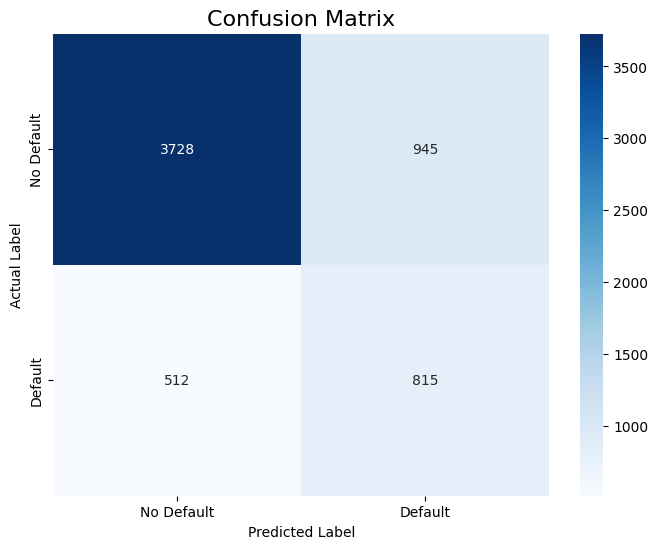

In [11]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Default', 'Default'],
            yticklabels=['No Default', 'Default'])
plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

### ROC and Precision-Recall Curves

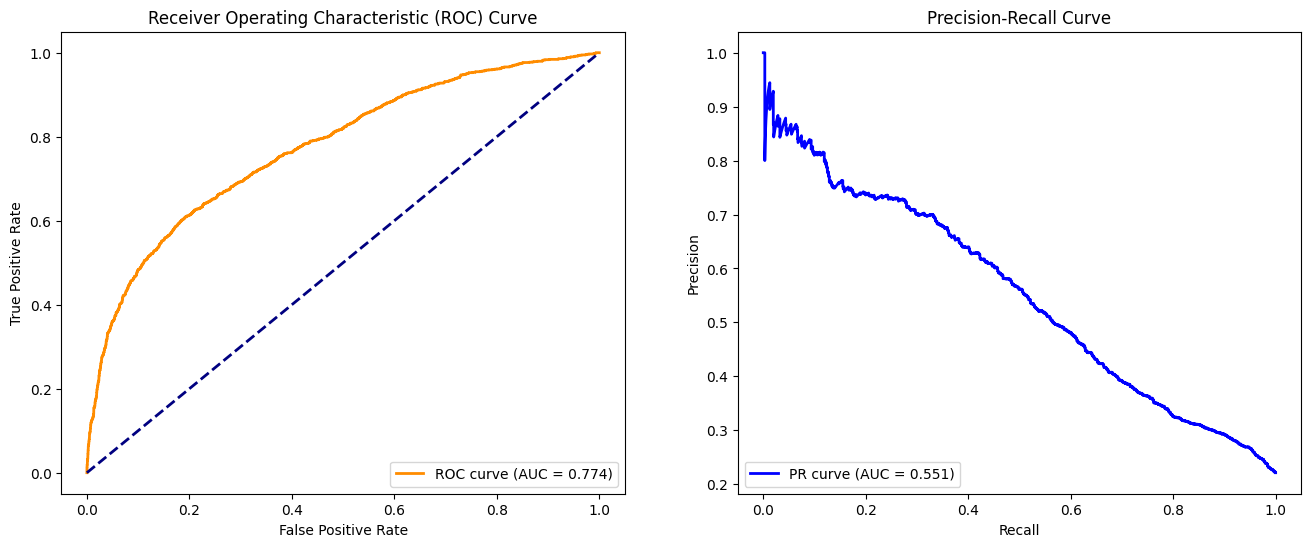

In [12]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# ROC Curve
ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver Operating Characteristic (ROC) Curve')
ax1.legend(loc="lower right")

# Precision-Recall Curve
ax2.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AUC = {pr_auc:.3f})')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve')
ax2.legend(loc="lower left")

plt.show()